In [1]:
##############################################################################
#                            LOGISTIC REGRESSION
##############################################################################

########## TABLE OF CONTENTS #############
# 1. Data read in
# 2. Data quality check
# 3. Data preparation
# 4. Model Training 
# 5. Model Evaluation

# Dataset -> Heart -> Taken from https://hastie.su.domains/ElemStatLearn/
######################

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt # Visualization
import seaborn as sns #Visualization
plt.rcParams['figure.figsize'] = [8,5]
plt.rcParams['font.size'] =14
plt.rcParams['font.weight']= 'bold'
import scipy 
from scipy import stats 
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, accuracy_score, auc
import statsmodels.formula.api as smf
import math
import warnings
warnings.filterwarnings('ignore')


def calculate_thresholds(n_records, n_bads, n_goods):
    # Total threshold
    if n_records <= 3000: tot_thresh = 0.1
    elif n_records > 3000 and n_records <= 5000: tot_thresh = 0.05
    elif n_records > 5000 and n_records <= 20000: tot_thresh = 0.03
    elif n_records > 20000 and n_records <= 50000: tot_thresh = 0.01
    else: tot_thresh = 0.005
    # Bad threshold
    if n_bads <= 3000: bad_thresh = 0.10
    elif n_bads > 3000 and n_bads <= 5000: bad_thresh = 0.05
    elif n_bads > 5000 and n_bads <= 20000: bad_thresh = 0.03
    elif n_bads > 20000 and n_bads <= 50000: bad_thresh = 0.01
    else:bad_thresh = 0.005
    # Good threshold
    if n_goods <= 3000: good_thresh = 0.10
    elif n_goods > 3000 and n_goods <= 5000: good_thresh = 0.05
    elif n_goods > 5000 and n_goods <= 20000: good_thresh = 0.03
    elif n_goods > 20000 and n_goods <= 50000: good_thresh = 0.01
    else: good_thresh = 0.005
    return tot_thresh, bad_thresh, good_thresh

def featureMonotonicBinning(Y, X, char):
    r = 0
    bad_flag = 0
    n = 20
    while np.abs(r) != 1 and bad_flag == 0:
        d1 = pd.DataFrame({"X": X, "Y": Y})
        d1["Value"], bins = pd.qcut(d1["X"], n, duplicates="drop", retbins=True, precision=3)
        if len(bins) == 2:
            bins = bins.tolist()
            bins.insert(0, float("-inf"))
            bins.append(float("+inf"))
            d1["Value"] = pd.cut(d1["X"], bins=bins, precision=3, include_lowest=True)
        d2 = d1.groupby("Value", as_index=True)
        r,p = stats.spearmanr(d2.mean().X, d2.mean().Y)
        d3, iv = calculate_scorecard(d1, "Value")
        d3.dropna(inplace=True)
        
        if len(d3) < 3:
            bad_flag = 1
        n = n-1
       
    pctThresh, badThresh, goodThresh = calculate_thresholds(d3["# Total"].sum(),d3["# Bad"].sum(),d3["# Good"].sum())
    condition = [(d3["% Total"] < pctThresh*100) | (d3["% Bad"] < badThresh*100) | (d3["% Good"] < goodThresh*100)]
    d3["Not Robust"] = np.select(condition, [1], 0)
    criteria = d3["Not Robust"].sum()
    d3 = d3.reset_index()
    while criteria > 0:
        i = d3[d3["Not Robust"] == 1].index[0]
        #if first row -> merge two first categories
        if i == 0:
            bins = np.delete(bins, 1)
        # if last row -> merge two last categories
        elif i == (len(d3) - 1):
            bins = np.delete(bins, len(d3)-1)
        else:
            # if number of samples greater in former -> merge with latter
            if (d3.at[i-1 , "# Total"] > d3.at[i+1 , "# Total"]):
                bins = np.delete(bins, i+1)
            # if number of samples greater in latter -> merge with former
            else:
                bins = np.delete(bins, i)        
        d1 = pd.DataFrame({"X": X, "Y": Y, "Value": pd.cut(X, bins, precision=3, include_lowest=True)})
        d3, iv = calculate_scorecard(d1, "Value")
        condition = [
            (d3["% Total"] < pctThresh*100) | 
            (d3["% Bad"] < badThresh*100) | 
            (d3["% Good"] < goodThresh*100) ]
        d3["Not Robust"] = np.select(condition, [1], 0)
        criteria = d3["Not Robust"].sum()
        d3 = d3.reset_index()
    d3 = d3.drop(columns=["Not Robust"])

    fig = plt.figure()    
    ax1 = fig.add_subplot(1,1,1)
    ax1.tick_params(axis='both', which='major', labelsize=8)
    ax1.tick_params(axis='both', which='minor', labelsize=8)
    ax1.plot(d3['WoE'], color = 'g')#,label='Predicted')
    display(iv)
    return d3, iv

def calculate_scorecard(d1, char):
    d2 = d1.groupby([char], dropna=False)
    d3 = pd.DataFrame(d2["X"].min(), columns=["min"])
    d3["# Good"] = d2["Y"].sum()
    d3["# Bad"] = d2["Y"].count() - d3["# Good"]
    d3["% Good"] = round(d3["# Good"] / d3["# Good"].sum() * 100, 1)
    d3["% Bad"] = round(d3["# Bad"] / d3["# Bad"].sum() * 100, 1)
    d3["# Total"] = d2["Y"].count()
    d3["% Total"] = round(d3["# Total"] / d3["# Total"].sum() * 100, 1)
    d3["Information Odds"] = round(d3["% Good"] / d3["% Bad"], 2)
    d3["Bad Rate"] = round(d3["# Bad"] / (d3["# Bad"] + d3["# Good"]) * 100, 2)
    d3["WoE"] = round(np.log(d3["% Good"] / d3["% Bad"]), 2)
    iv = (d3["% Good"] - d3["% Bad"]) * d3["WoE"] / 100
    d4 = d3.sort_index().drop(columns=["min"], axis=1)
    return d4, iv


# The Logistic Regression model requires several key assumptions. These are as follows:-
# 1. Logistic Regression model requires the dependent variable to be binary, multinomial or ordinal in nature.
# 2. It requires the observations to be independent of each other. So, the observations should not come from repeated measurements.
# 3. Logistic Regression algorithm requires little or no multicollinearity among the independent variables. 
      # It means that the independent variables should not be too highly correlated with each other.
# 4. Logistic Regression model assumes linearity of independent variables and log odds.
# 5. The success of Logistic Regression model depends on the sample sizes. Typically, 
      # it requires a large sample size to achieve the high accuracy.

1. DATA READ IN

In [2]:
df = pd.read_csv("Heart.txt", index_col=0)
df

# sbp		systolic blood pressure
# tobacco	cumulative tobacco (kg)
# ldl		low densiity lipoprotein cholesterol
# adiposity
# famhist	family history of heart disease (Present, Absent)
# typea		type-A behavior
# obesity
# alcohol	current alcohol consumption
# age		age at onset
# chd		response, coronary heart disease  -> TARGET VARIABLE

,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
1,160,12.00,5.73,23.11,Present,49,25.30,97.20,52,1
2,144,0.01,4.41,28.61,Absent,55,28.87,2.06,63,1
3,118,0.08,3.48,32.28,Present,52,29.14,3.81,46,0
4,170,7.50,6.41,38.03,Present,51,31.99,24.26,58,1
5,134,13.60,3.50,27.78,Present,60,25.99,57.34,49,1
...,...,...,...,...,...,...,...,...,...,...
459,214,0.40,5.98,31.72,Absent,64,28.45,0.00,58,0
460,182,4.20,4.41,32.10,Absent,52,28.61,18.72,52,1
461,108,3.00,1.59,15.23,Absent,40,20.09,26.64,55,0
462,118,5.40,11.61,30.79,Absent,64,27.35,23.97,40,0


2. DATA QUALITY CHECK

famhist
Absent     270
Present    192
Name: count, dtype: int64

'Shape: '

(462, 10)

<class 'pandas.core.frame.DataFrame'>
Index: 462 entries, 1 to 463
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sbp        462 non-null    int64  
 1   tobacco    462 non-null    float64
 2   ldl        462 non-null    float64
 3   adiposity  462 non-null    float64
 4   famhist    462 non-null    object 
 5   typea      462 non-null    int64  
 6   obesity    462 non-null    float64
 7   alcohol    462 non-null    float64
 8   age        462 non-null    int64  
 9   chd        462 non-null    int64  
dtypes: float64(5), int64(4), object(1)
memory usage: 39.7+ KB


'Info'

None

'Describe'

,sbp,tobacco,ldl,adiposity,typea,obesity,alcohol,age,chd
count,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000
mean,138.326840,3.635649,4.740325,25.406732,53.103896,26.044113,17.044394,42.816017,0.346320
std,20.496317,4.593024,2.070909,7.780699,9.817534,4.213680,24.481059,14.608956,0.476313
min,101.000000,0.000000,0.980000,6.740000,13.000000,14.700000,0.000000,15.000000,0.000000
25%,124.000000,0.052500,3.282500,19.775000,47.000000,22.985000,0.510000,31.000000,0.000000
50%,134.000000,2.000000,4.340000,26.115000,53.000000,25.805000,7.510000,45.000000,0.000000
75%,148.000000,5.500000,5.790000,31.227500,60.000000,28.497500,23.892500,55.000000,1.000000
max,218.000000,31.200000,15.330000,42.490000,78.000000,46.580000,147.190000,64.000000,1.000000


'Checking duplicates'

0

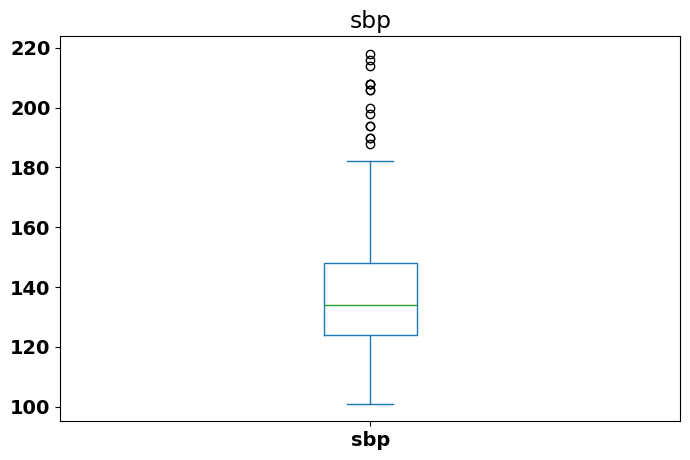

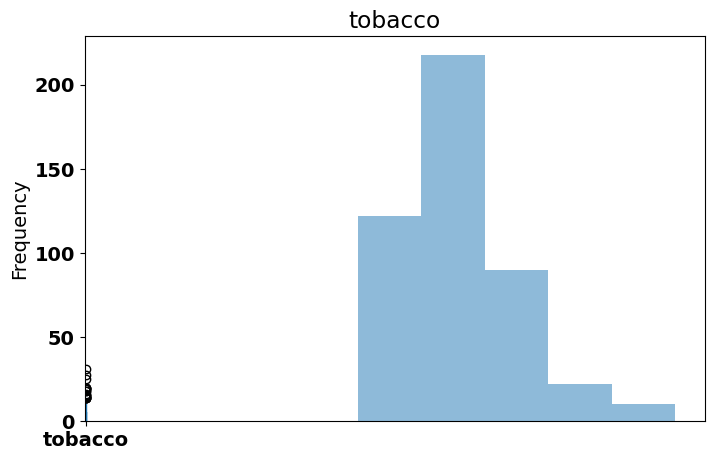

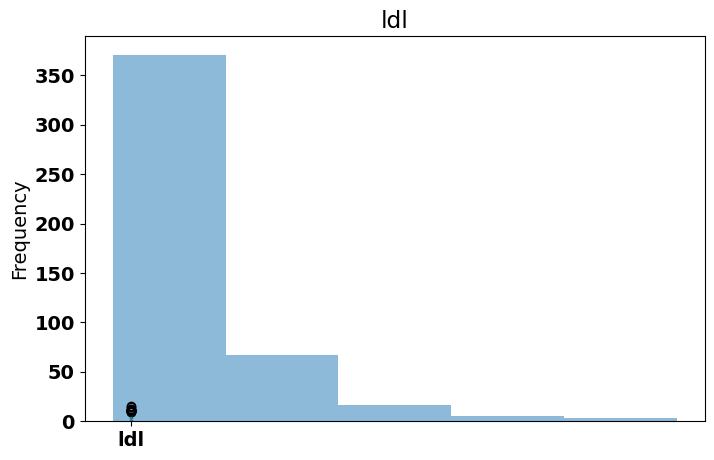

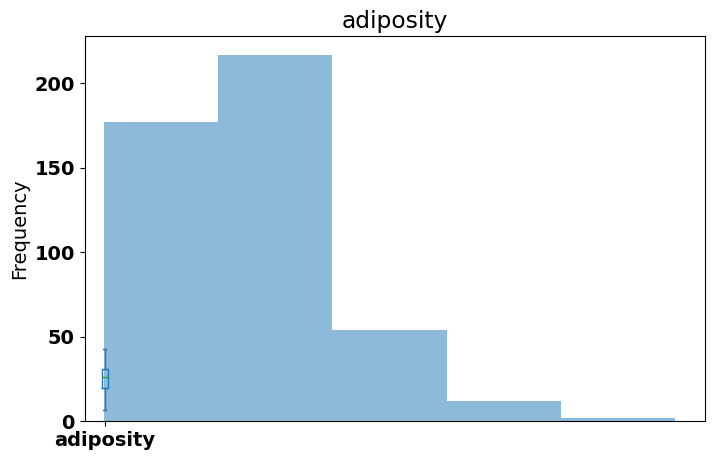

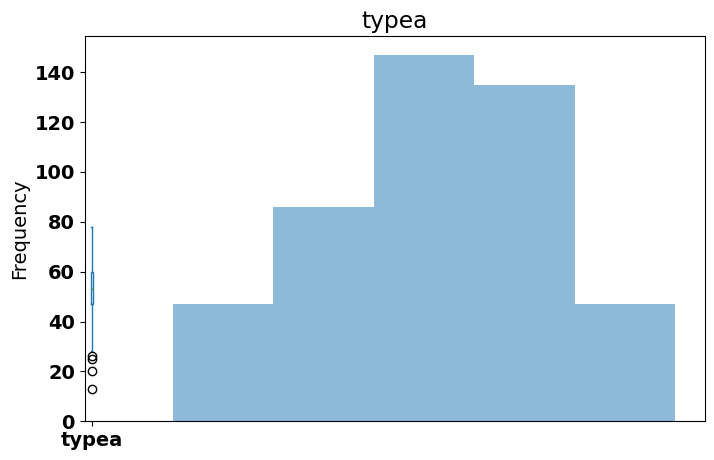

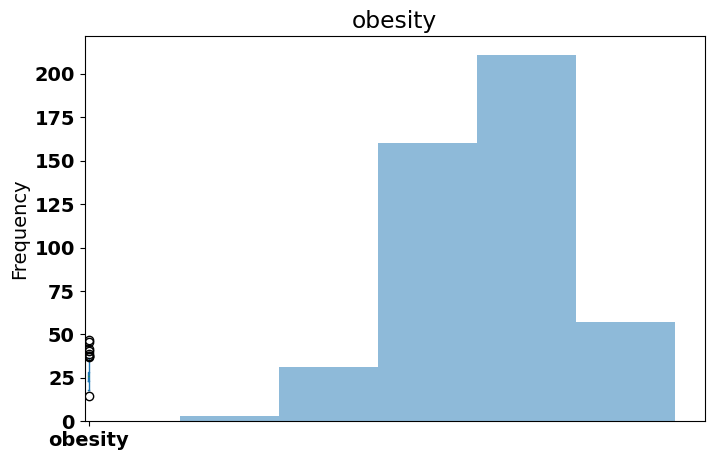

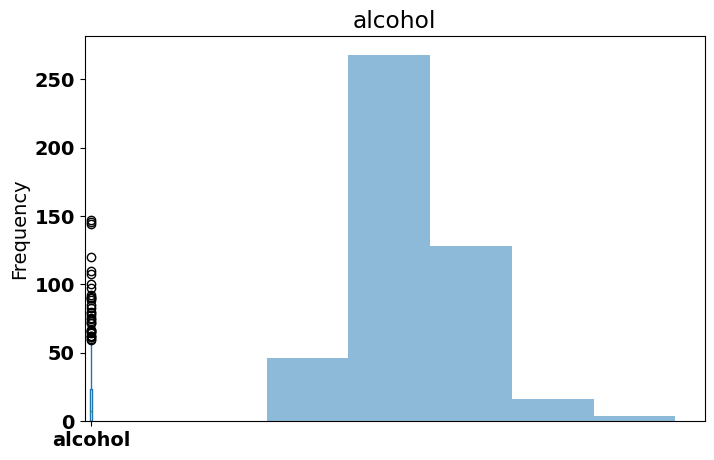

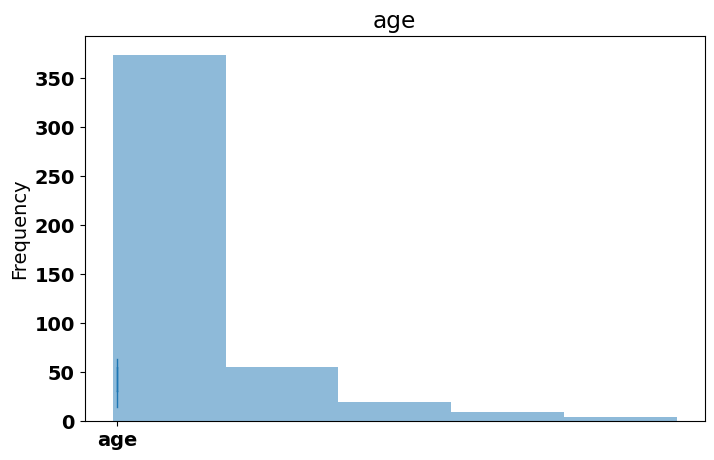

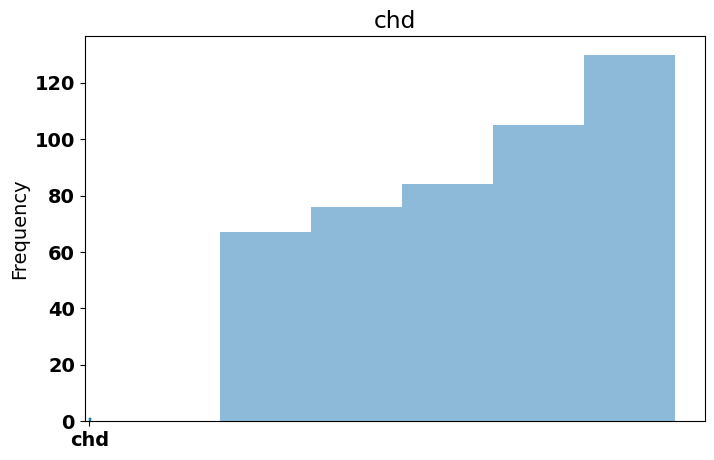

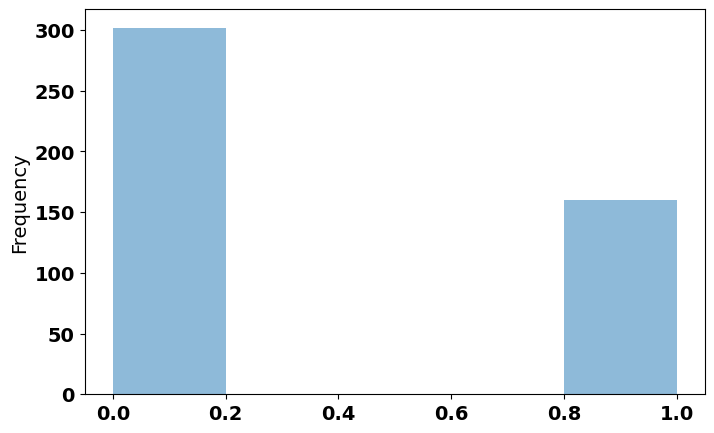

In [13]:
display(df['famhist'].value_counts())
display("Shape: ",df.shape)
display("Info",df.info())
display("Describe",df.describe())

display("Checking duplicates")
display(df.duplicated(keep=False).sum())

# Create Box-Plots
cols = list(df.columns)

for i in range(len(cols)):
    if (df[cols[i]].dtype != object):
        df[cols[i]].plot(kind='box', title=cols[i]) 
        plt.show() 
        ax = df[cols[i]].plot.hist(bins=5, alpha=0.5)



if False:
    cols = list(df.columns)
    cols.remove("chd")

    for i in range(len(cols)):
        if(df[cols[i]].dtype != object):
            display(cols[i])
            display(featureMonotonicBinning(df['chd'], df[cols[i]], cols[i]))



3. DATA PREPARATION

In [14]:
# From Categorical to Numeric transformation
df['familiarity'] = np.where(df['famhist'] == "Absent",0,np.where(df['famhist'] == "Present",1,-1))

ds = df.drop(columns=['famhist','adiposity','sbp','alcohol','obesity'], axis=1)
X = ds.drop(columns=['chd'], axis = 1)
Y = ds['chd']

# Correlation
corr = ds.corr()
display(corr)
corr.style.background_gradient(cmap='coolwarm')

,tobacco,ldl,typea,age,chd,familiarity
tobacco,1.000000,0.158905,-0.014608,0.450330,0.299718,0.088601
ldl,0.158905,1.000000,0.044048,0.311799,0.263053,0.161353
typea,-0.014608,0.044048,1.000000,-0.102606,0.103156,0.044809
age,0.450330,0.311799,-0.102606,1.000000,0.372973,0.239667
chd,0.299718,0.263053,0.103156,0.372973,1.000000,0.272373
familiarity,0.088601,0.161353,0.044809,0.239667,0.272373,1.000000


,tobacco,ldl,typea,age,chd,familiarity
tobacco,1.000000,0.158905,-0.014608,0.450330,0.299718,0.088601
ldl,0.158905,1.000000,0.044048,0.311799,0.263053,0.161353
typea,-0.014608,0.044048,1.000000,-0.102606,0.103156,0.044809
age,0.450330,0.311799,-0.102606,1.000000,0.372973,0.239667
chd,0.299718,0.263053,0.103156,0.372973,1.000000,0.272373
familiarity,0.088601,0.161353,0.044809,0.239667,0.272373,1.000000


4. MODEL TRAINING

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.5, random_state = 0)

cols = X_train.columns
#Standardize features
for i in range(len(cols)):
    # Z-Score using scipy 
    X[cols[i]] = stats.zscore(X[cols[i]]) 

X1 = sm.add_constant(X_train)
logit = sm.Logit(y_train,X1)
results = logit.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.522773
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    chd   No. Observations:                  231
Model:                          Logit   Df Residuals:                      225
Method:                           MLE   Df Model:                            5
Date:                Thu, 02 May 2024   Pseudo R-squ.:                  0.1963
Time:                        17:03:10   Log-Likelihood:                -120.76
converged:                       True   LL-Null:                       -150.26
Covariance Type:            nonrobust   LLR p-value:                 1.957e-11
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -6.2272      1.294     -4.811      0.000      -8.764      -3.690
tobacco         0.1229      0.039      3.146      0.002       0.046       0.199
ldl             0.1098      0.071      1.545      0.122      -0.030       0.249
typea           0.0435      0.018      2.485      0.013       0.009       0.078
age             0.0414      0.014      2.968      0.003       0.014       0.069
familiarity     0.7942      0.317      2.504      0.012       0.173       1.416
===============================================================================
"""

5. MODEL EVALUATION

Model accuracy score: 0.7186
Confusion matrix

 [[136  17]
 [ 48  30]]

True Positives(TP) =  136

True Negatives(TN) =  30

False Positives(FP) =  17

False Negatives(FN) =  48
              precision    recall  f1-score   support

           0       0.74      0.89      0.81       153
           1       0.64      0.38      0.48        78

    accuracy                           0.72       231
   macro avg       0.69      0.64      0.64       231
weighted avg       0.71      0.72      0.70       231



114    0.388743
22     0.473542
79     0.321202
119    0.615151
226    0.308147
         ...   
219    0.028931
47     0.832686
376    0.284910
452    0.129659
280    0.035020
Length: 231, dtype: float64

                 
Test Gini:   57.5
                 


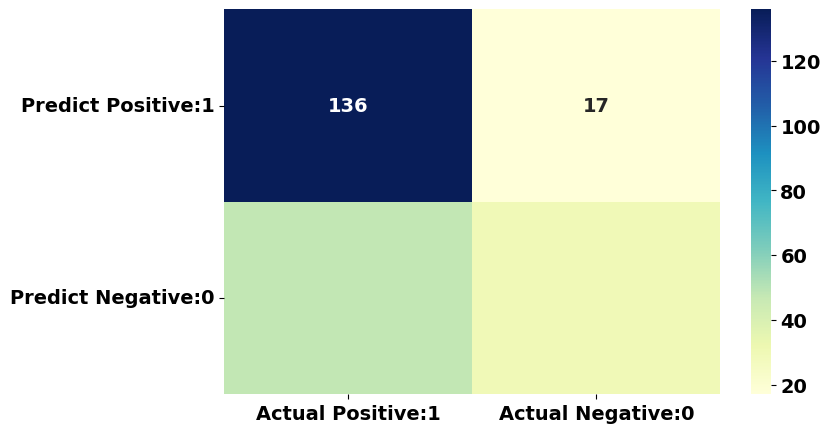

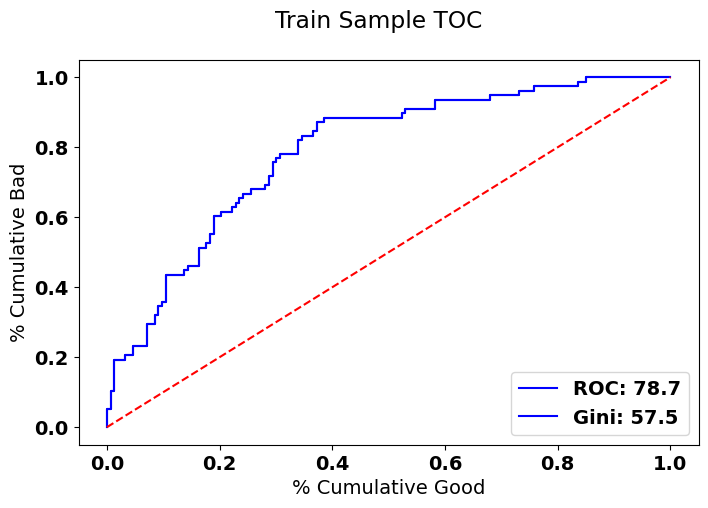

In [16]:
# instantiate the model
logreg = LogisticRegression(solver='liblinear', random_state=0)
# fit the model
logreg.fit(X1, y_train)

X1 = sm.add_constant(X_test)
y_pred_test = logreg.predict(X1)
y_pred_proba = results.predict(X1)
y_pred_test
y_pred_proba 
print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred_test)))


cm = confusion_matrix(y_test, y_pred_test)

print('Confusion matrix\n\n', cm)

print('\nTrue Positives(TP) = ', cm[0,0])

print('\nTrue Negatives(TN) = ', cm[1,1])

print('\nFalse Positives(FP) = ', cm[0,1])

print('\nFalse Negatives(FN) = ', cm[1,0])

# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

print(classification_report(y_test, y_pred_test))

display(y_pred_proba)

fpr,tpr,threshold=roc_curve(y_test,y_pred_proba)
rocauc=auc(fpr,tpr)*100
x = round((rocauc-50)*2,1)



print("                 ")
print("Test Gini:  ",x)
print("                 ")



fig = plt.figure()    
fig.suptitle('Train Sample TOC')
ax1 = fig.add_subplot(1,1,1)
plt.plot(fpr,tpr,'b',label='ROC: %0.1f'% rocauc)
plt.plot(fpr,tpr,'b',label='Gini: %0.1f'% x)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlabel('% Cumulative Good')
plt.ylabel('% Cumulative Bad')
plt.show()